### OtoWorld
Welcome to OtoWorld, an interactive environment where agents must learn to listen in order to solve navigational tasks. 

OtoWorld is built on three open source libraries: OpenAI Gym for environment and agent interaction, Pyroomacoustics for ray-tracing and acoustics simulation, and nussl for training deep computer audition models. 

OtoWorld can be easily extended to more complex environments and games. To solve one episode of OtoWorld, an agent must move towards each sounding source in the auditory scene and 'turn it off'. The agent receives no other input other than the current sound of the room. The sources are placed randomly within the room and can vary in number. The agent receives a reward for turning off a source.

In [2]:
import sys
sys.path.append("../src")

import audio_room
import room_types
from agent import OracleAgent
import gym
import nussl
from datasets import BufferData
import constants
import utils
import numpy as np

import warnings
warnings.filterwarnings('ignore')

nussl.utils.seed(42)

### Important files/packages to know
- audio_room

This is a package that holds all the source code for the environment. Here, you can read about the various configurable parameters for an environment. 

- agent.py

This file contains the agents, including a perfect and random agent, which will be used to navigate a room. We recommend that you follow a similar code structure to the pre-defined agents. The reason why is because our code makes it as easy as possible for researchers to build agents and save their models. In order to build an valid agent, only four functions must be implemented.

- constants.py

This file contains some of the parameters used to penalize/reward an agent, build a trainable dataset, and more.

- datasets.py

This file contains the source code responsible for building a dataset by capturing the state information, rewards, and actions.

- utils.py

This file contains utility functions that make the OtoWorld workflow simplier.

- room_types.py

This file allows you to create simple polygon and shoebox rooms.

### Creating your rooms
Rooms are created using the Pyroomacoustics library. Users can create simple Shoebox (rectangular) room or create more complicated n-shaped polygon rooms. Through Pyroomacoustics, the environment supports the creation of rooms with different wall materials, energy absorption rates, temperatures, and humidity. 

You can create rooms either by importing room_types or by directly using the Pyroomacoustics library.

In [3]:
# Create a square 5x5 room using room_types
square_room = room_types.ShoeBox(x_length=4, y_length=4)

### Logging information & building a trainable dataset
Once we create a room to navigate, we have to create a buffer folder in order to build a dataset. We can do this by calling the utils create_buffer_data_folders() function. This function will create three folders that store the dataset items, states and previous states. The path to the dataset folder is defined and configurable in constants.py.

In [4]:
# create buffer data folders and dataset
utils.create_buffer_data_folders()
dataset = BufferData(folder=constants.DIR_DATASET_ITEMS, to_disk=False)

### Creating an Audio Environment
Since audio_room is built on top of OpenAI Gym, creating an environment requires gym. All of the configurable parameters can be found in audio_env.py. A few of the more important params are:
- room_config (List or np.array): dimensions of the room. For Shoebox, in the form of [10,10]. Otherwise,
    in the form of [[1,1], [1, 4], [4, 4], [4, 1]] specifying the corners of the room
- step_size (float): specified step size else we programmatically assign it
- acceptable_radius (float): source is considered found/turned off if agent is within this distance of src
- num_sources (int): the number of audio sources the agent will listen to
- degrees (float): value of degrees to rotate in radians (.2618 radians = 15 degrees)

In [5]:
# Dictionary tells the environment where to read audio files from
# and how many audio files to read in from each folder for every episode
source_folders_dict = {"../sounds/samples/female" : 1, "../sounds/samples/male" : 1}

# Set up the gym environment
env = gym.make(
    "audio-room-v0",
    source_folders_dict=source_folders_dict,
    room_config=square_room.generate(),
    corners=square_room.corners,
    max_order=10,
    step_size=1.0,
    num_sources=2,
    acceptable_radius=1.0,
    reset_sources=False,
    same_config=True
)
env.seed(42)

Source locs [[3.209240790978062, 3.0944664885587816], [1.9999999999999996, 0.4402898233418924]]
Placing agent at [0.027808522124762813, 2.042989210310263]


We can optionally listen to the audio the agent hears at every step. For the purpose of this tutorial, we will only listen to the audio in the 0th step.

In [6]:
env.room.compute_rir()
env.room.simulate()
data = env.room.mic_array.signals

# Convert data to nussl audio signal
data = nussl.AudioSignal(audio_data_array=data, sample_rate=env.resample_rate)
data.embed_audio(display=False)

### Creating your own agent
In order to create your own navigational agent, you must create a subclass of the AgentBase class found in the src/agent.py. There are four functions that must be implemented.
1. choose_action()
This function will decide what action you take from the action space given the current state.
2. update()
This function will update the q-network
3. update_stable_network()
This function will update the stable network
4. save_model()
This function periodically will save whatever parameters you find to be valuable i.e. it saves the model

Once these functions are implemented, call agent.fit() to start an experiment.


NOTE: Since this is a perfect agent, it is necessary to make epsilon 0 since we know what action we need to take. In order to change epsilon, all we need to do is update the MAX_EPSILON and MIN_EPSILON constants in constants.py to 0s.

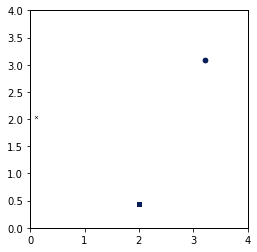

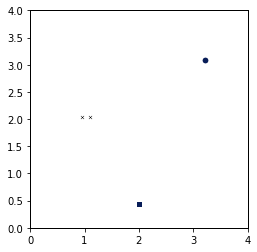

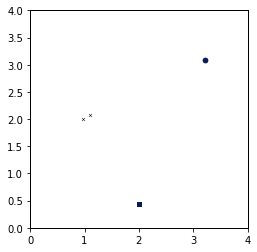

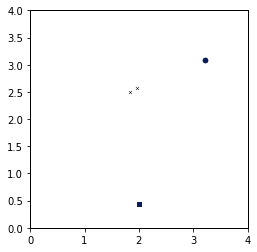

Agent has found source ../sounds/samples/female/050a050a.wav. 
Agent loc: [2.75985811 3.04299133], Source loc: [3.209240790978062, 3.0944664885587816]


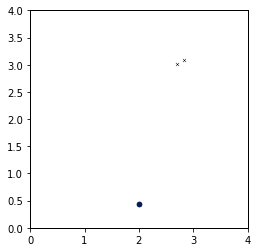

INFO:root:In FIT. Received reward 99.5 at step: 4



In FIT. Received reward: 99.5 at step 4



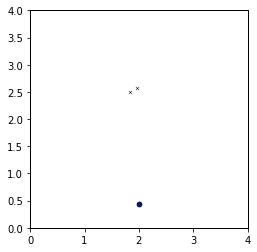

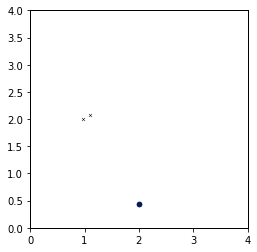

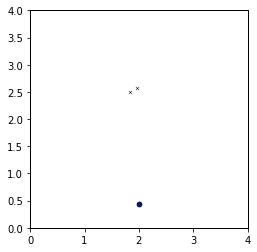

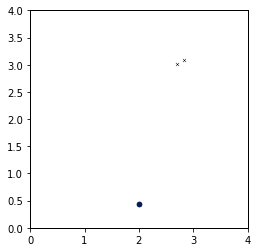

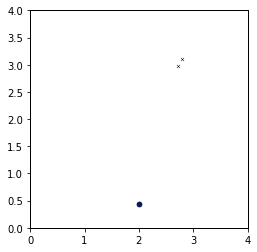

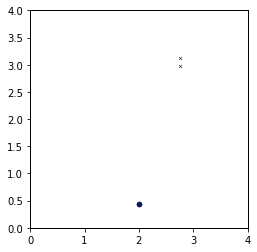

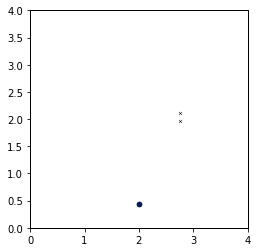

INFO:root:In FIT. Received reward 99.5 at step: 12

INFO:root:

Episode Summary 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Episode: 1
- Won?: True
- Finished at step: 13
- Time taken:   14.834501 
- Steps/Second: 0.876336 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



Agent has found source ../sounds/samples/male/051a050c.wav. 
Agent loc: [2.75986545 1.04299133], Source loc: [1.9999999999999996, 0.4402898233418924]
Source locs [[3.209240790978062, 3.0944664885587816], [1.9999999999999996, 0.4402898233418924]]
Placing agent at [0.027808522124762813, 2.042989210310263]
In FIT. Received reward: 99.5 at step 12



Episode Summary 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Episode: 1
- Won?: True
- Finished at step: 13
- Time taken:   14.834501 
- Steps/Second: 0.876336 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Source locs [[3.209240790978062, 3.0944664885587816], [1.9999999999999996, 0.4402898233418924]]
Placing agent at [0.027808522124762813, 2.042989210310263]


In [7]:
agent = OracleAgent(env, dataset, show_room=True, play_audio=False, max_steps=100)
agent.fit()